In [26]:
"""
================================
        Data pre-processing
         Angle correction
================================

(See the project documentation for more info)

The goal is to process data before using it to train ML algorithms :
1. Extraction of accelerations for activity 1 (rest activity)
2. Transitory regime suppression on activity 1
3. Calculation of theta angle between Z' and Z (ground's normal axis)
4. System rotation towards Z earth axis
5. Offset removal

Note that the solver fails to find a solution at step 3
"""
print(__doc__)


        Data pre-processing
         Angle correction

(See the project documentation for more info)

The goal is to process data before using it to train ML algorithms :
1. Extraction of accelerations for activity 1 (rest activity)
2. Transitory regime suppression on activity 1
3. Calculation of theta angle between Z' and Z (ground's normal axis)
4. System rotation towards Z earth axis
5. Offset removal

Note that the solver fails to find a solution at step 3



In [27]:
# Imports statements

import pandas as pd
import numpy as np
# from math import cos, sin
from utils.colorpalette import black, red, blue, green, yellow, pink, brown, violet
from utils.activities import activities_labels
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D 

In [28]:
# Import data into memory

raw_data = pd.read_csv('../data/1.csv',header=None,delimiter=',').astype(int)
raw_data.head()

,0,1,2,3,4
0,0.0,1502,2215,2153,1
1,1.0,1667,2072,2047,1
2,2.0,1611,1957,1906,1
3,3.0,1601,1939,1831,1
4,4.0,1643,1965,1879,1


In [29]:
# Prepare further plotting activities
color_map = np.array([black, red, blue, green, yellow, pink, brown, violet])
axe_name = ['X', 'Y', 'Z']
activities = np.array(raw_data[4]-1) # -1 is here to shift the table correctly to work with the color_map
x_min, x_max = raw_data[0].min() - 1, raw_data[0].max() + 1

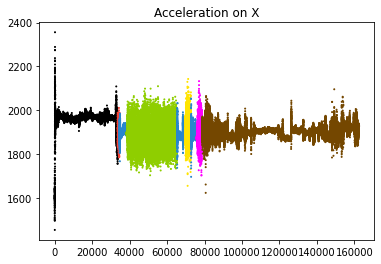

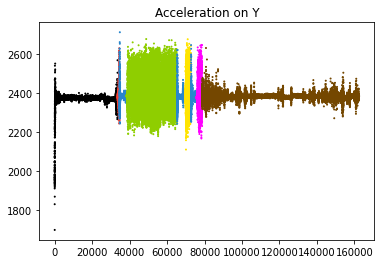

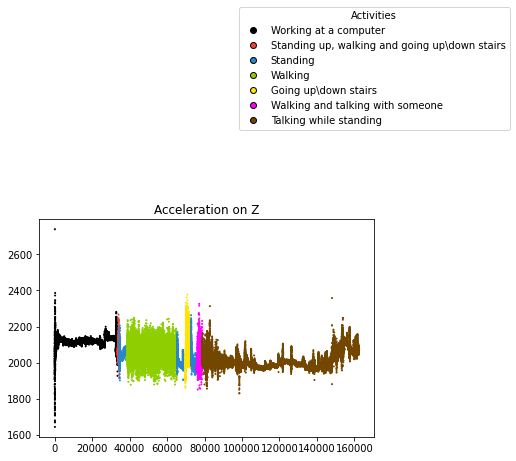

In [22]:
# Show data before processing
y_min, y_max, xx, yy, fig, subplot  = [], [], [], [], [], []
legend = []
for activity, color in zip(activities_labels, color_map):
    legend.append(Line2D([0], [0], marker='o', label=activity, ls='None', markerfacecolor=color, markeredgecolor='k'))
for k in range(0,3):
    y_min.append(raw_data[k+1].min() - 1)
    y_max.append(raw_data[k+1].max() + 1)
    xx_tmp, yy_tmp = np.meshgrid(np.arange(x_min, x_max, 1000),np.arange(y_min[k], y_max[k], 100))
    xx.append(xx_tmp)
    yy.append(yy_tmp)
    fig.append(plt.figure())
    subplot.append(fig[k].add_subplot(111))
    subplot[k].scatter(raw_data[0], raw_data[k+1], s=1,c=color_map[activities])
    subplot[k].set_title('Acceleration on ' + axe_name[k])
legend = plt.legend(handles=legend, loc='upper center', bbox_to_anchor=(1, 2), title='Activities')
plt.show()

In [23]:
#Prepare for processing
clean_data = []
clean_data.append(raw_data[0])

In [24]:
# Transitory regime suppression on activity 1
np_raw_data = np.array(raw_data, dtype=object)
bool_mask_on_act_1 = np_raw_data[:, 4] == 1 # Boolean mask to only select rows concerning activity 1
bool_mask_on_permanent_regime = (np_raw_data[:, 0] >= 3200) & (np_raw_data[:, 0] <= 16000)
act_1_data_permanent_regime = np_raw_data[bool_mask_on_act_1 & bool_mask_on_permanent_regime]

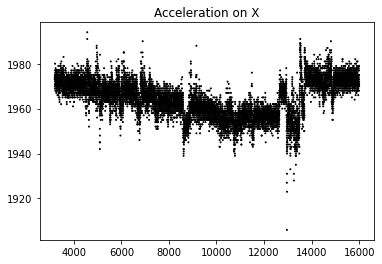

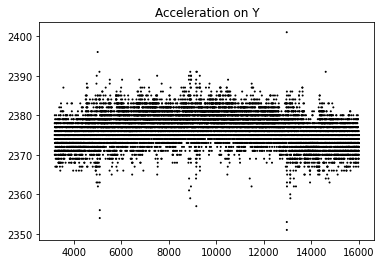

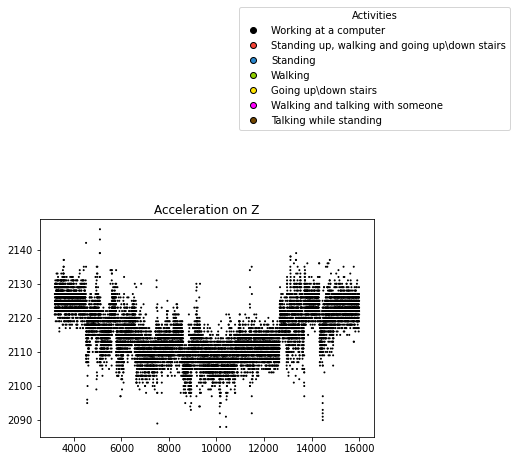

In [25]:
# Show activity 1 data after transitory regime suppression on activity 1
activities = np.array(act_1_data_permanent_regime[:,4]-1, dtype=int) # -1 is here to shift the table correctly to work with the color_map

x_min, x_max = act_1_data_permanent_regime[0].min() - 1, act_1_data_permanent_regime[0].max() + 1
y_min, y_max, xx, yy, fig, subplot  = [], [], [], [], [], []
legend = []
for activity, color in zip(activities_labels, color_map):
    legend.append(Line2D([0], [0], marker='o', label=activity, ls='None', markerfacecolor=color, markeredgecolor='k'))
for k in range(0,3):
    y_min.append(act_1_data_permanent_regime[k+1].min() - 1)
    y_max.append(act_1_data_permanent_regime[k+1].max() + 1)
    xx_tmp, yy_tmp = np.meshgrid(np.arange(x_min, x_max, 1000),np.arange(y_min[k], y_max[k], 100))
    xx.append(xx_tmp)
    yy.append(yy_tmp)
    fig.append(plt.figure())
    subplot.append(fig[k].add_subplot(111))
    subplot[k].scatter(act_1_data_permanent_regime[:,0], act_1_data_permanent_regime[:,k+1], s=1,c=color_map[activities])
    subplot[k].set_title('Acceleration on ' + axe_name[k])
legend = plt.legend(handles=legend, loc='upper center', bbox_to_anchor=(1, 2), title='Activities')
plt.show()

In [30]:
index_mean, xp_mean, yp_mean, zp_mean, activity_mean = act_1_data_permanent_regime.mean(axis=0)

In [36]:
# Look for theta value :
from sympy.solvers import solve
from sympy import Symbol, sin, cos
from math import sqrt

index_mean, xp_mean, yp_mean, zp_mean, activity_mean = act_1_data_permanent_regime.mean(axis=0)
abs_gamma_mean = sqrt(xp_mean**2+yp_mean**2+zp_mean**2)
theta = Symbol('theta')
index_mean, xp_mean, yp_mean, zp_mean, activity_mean = act_1_data_permanent_regime.mean(axis=0)
theta = solve(sin(theta)*yp_mean+cos(theta)*zp_mean, abs_gamma_mean, dict=True)
# TODO : Find a way that this equation returns results !

In [ ]:
# System rotation towards Z earth axis - see the report for documentation
rotation_matrix = np.array([[1, 0, 0],
                            [0, cos(theta), -sin(theta)]
                            [0, sin(theta), cos(theta)]])

for row_index in clean_data:
    Gamma_xp_yp_zp = clean_data.iloc[row_index][1, 2, 3]
    Gamma_x_y_z = np.matmul(rotation_matrix, Gamma_xp_yp_zp)
    clean_data.iloc[row_index][1, 2, 3] = Gamma_x_y_z

In [ ]:
# Offset suppression

# TODO :
# Should we really delete the offset though? Maybe it just corresponds to gravity, so change of system first !
# At rest, Gamma is expected to be 1g, but is calculated to be around 3,7g.
# So there might be offsets, indeed, but in which direction?

mean_acc_by_act = raw_data[[1, 2, 3, 4]].groupby([4], as_index=False).mean().sort_values(by=4, ascending=True)
mean_acc_at_act_1 = mean_acc_by_act.iloc[0] # Offset is calculated at rest (activity 1)

for k in range(1,4):
    clean_data.append(raw_data[k] - mean_acc_at_act_1[k])

In [ ]:
# Show changes after offset suppression
legend = []
for activity, color in zip(activities_labels, color_map):
    legend.append(Line2D([0], [0], marker='o', label=activity, ls='None', markerfacecolor=color, markeredgecolor='k'))

y_min, y_max, xx, yy, fig, subplot  = [], [], [], [], [], []
for k in range(0,3):
    y_min.append(clean_data[k+1].min() - 1)
    y_max.append(clean_data[k+1].max() + 1)
    xx_tmp, yy_tmp = np.meshgrid(np.arange(x_min, x_max, 1000),np.arange(y_min[k], y_max[k], 100))
    xx.append(xx_tmp)
    yy.append(yy_tmp)
    fig.append(plt.figure())
    subplot.append(fig[k].add_subplot(111))
    subplot[k].scatter(clean_data[0], clean_data[k+1], s=1,c=color_map[activities])
    subplot[k].set_title('Acceleration on ' + axe_name[k])
legend = plt.legend(handles=legend, loc='upper center', bbox_to_anchor=(1, 2), title='Activities')
plt.show()

In [12]:
# Push data changes into new csv file
df = pd.DataFrame(clean_data)
df.to_csv("../../data/cleaned_data/projected_on_z_axis_1.csv",index=False)